## 19.1 SHAP
SHAP (SHapley Additive exPlanations) is a game-theoretic approach that can provide both global and local explanations for a model's behavior. It can model non-linear relationships and rank the importance of features while also indicating the direction of their impact.

One interesting fact about SHAP is that it can be used to explain not only black box models but also white box models. Additionally, it is based on the classic Shapley values from game theory and their related extensions.

In [1]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile
from hyperopt import fmin, tpe, hp, Trials
from EffectiveXGBoost import *

import xgbfir

path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test = pline.transform(kag_X_test)

# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

# Default training
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:62: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [2]:
step_params = {'random_state': 42,
    'max_depth': 5,
    'min_child_weight': 0.6411044640540848,
    'subsample': 0.9492383155577023,
    'colsample_bytree': 0.6235721099295888,
    'gamma': 0.00011273797329538491,
    'learning_rate': 0.24399020050740935}
xg_step = xgb.XGBClassifier(**step_params, 
                            early_stopping_rounds=50, 
                            n_estimators=500
                           )
xg_step.fit(X_train, y_train,
            eval_set=[(X_train, y_train), 
                      (X_test, y_test)],
            verbose=False
           )

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6235721099295888, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None,
              gamma=0.00011273797329538491, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.24399020050740935, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=0.6411044640540848, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [3]:
import shap
shap.initjs()
shap_ex = shap.TreeExplainer(xg_step)
vals = shap_ex(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [4]:
shap_df = pd.DataFrame(vals.values, columns=X_test.columns)
print(shap_df)

          age  education  years_exp  compensation    python         r  \
0    0.305226   0.439692  -0.253296      0.188845 -0.006573  0.404579   
1    0.024015  -0.159773  -0.455850     -0.082645 -0.005427 -1.010973   
2   -0.431262  -0.071911  -0.402804      0.010262  0.115035  0.465523   
3   -0.009354  -0.310885  -0.554206     -0.305342 -0.110712  0.311385   
4   -0.480810  -0.165381  -0.340763      0.025287  0.081944  0.343087   
..        ...        ...        ...           ...       ...       ...   
900  0.218955  -0.074453   0.050799     -0.220896 -0.005685 -1.251164   
901  0.201146   0.566801  -0.318655      0.474865 -0.084310  0.391499   
902 -0.276537   0.041904   1.082182      0.023251  0.088998  0.495281   
903 -0.233034   0.437283  -0.307598     -0.135428 -0.064209 -1.063651   
904 -0.169017   0.537947   1.446973     -0.142602 -0.085405  0.484191   

          sql   Q1_Male  Q1_Female  Q1_Prefer not to say  \
0   -0.017500  0.014423  -0.006778              0.001413   
1  

how to use SHAP values and the `base_values` attribute of a TreeExplainer object to compute the log odds value for a sample being in the positive class. Log odds is a way of expressing the probability of an event occurring. It is calculated as the logarithm of the odds, where odds is defined as the probability of an event occurring divided by the probability of it not occurring.

The `base_values` attribute represents the default prediction for the model, which is also known as the expected value. By summing the SHAP values for each row and adding the `base_values` attribute, you can obtain the log odds value for that sample.

to convert the log odds value into a probability by adding it to a DataFrame with a column named `pred` and including the ground truth value. The log odds value can then be converted into a probability by adding a `prob` column. If the probability is above 0.5 (i.e., if `pred` is positive), then the positive value is predicted.


In [5]:
print(pd.concat([shap_df.sum(axis='columns')
 .rename('pred') + vals.base_values, pd.Series(y_test, name='true')], axis='columns')
 .assign(prob=lambda adf: (np.exp(adf.pred) / (1 + np.exp(adf.pred))))
)


         pred  true      prob
0    1.318039     1  0.788855
1   -2.277270     0  0.093023
2   -1.623289     0  0.164752
3   -0.582778     1  0.358294
4   -0.426642     1  0.394929
..        ...   ...       ...
900 -2.350266     0  0.087045
901  1.828284     0  0.861557
902  0.867635     0  0.704253
903 -2.112605     0  0.107878
904  1.336381     1  0.791894

[905 rows x 3 columns]


## 19.2 Examining a Single Prediction

In [6]:
X_test.iloc[0]

age                            22.0
education                      16.0
years_exp                       1.0
compensation                    0.0
python                          1.0
r                               0.0
sql                             0.0
Q1_Male                         1.0
Q1_Female                       0.0
Q1_Prefer not to say            0.0
Q1_Prefer to self-describe      0.0
Q3_United States of America     0.0
Q3_India                        1.0
Q3_China                        0.0
major_cs                        1.0
major_other                     0.0
major_eng                       0.0
major_stat                      0.0
Name: 7894, dtype: float64

In [7]:
# predicts software engineer... why?
xg_step.predict(X_test.iloc[[0]])

array([1])

In [8]:
# ground truth
y_test[0]

1

In [9]:
# Since this is below zero, the default is Data Scientist
shap_ex.expected_value

-0.2106393

In [10]:
# > 0 therefore ... Software Engineer
shap_ex.expected_value + vals.values[0].sum()

1.3180392

Because this value is above 0, we would predict Software Engineer for this sample.
## 19.3 Waterfall Plots

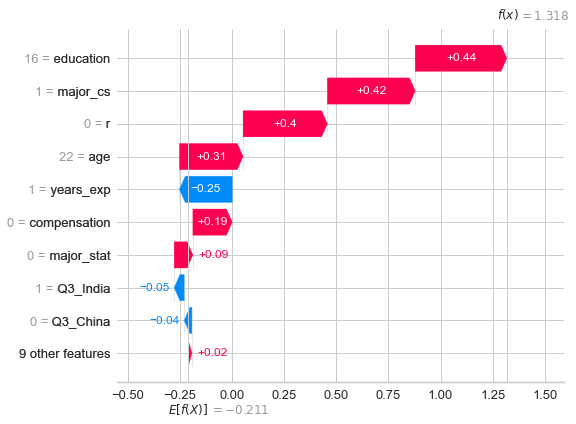

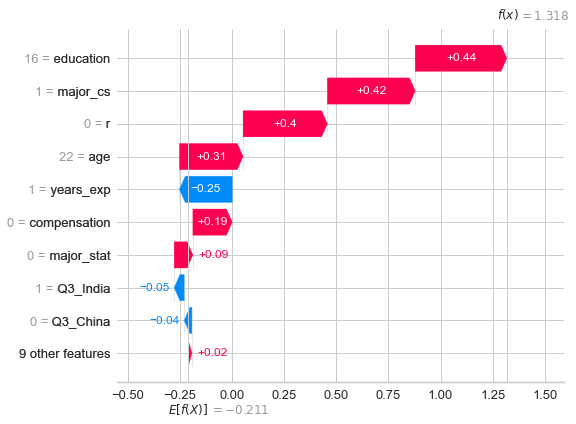

In [11]:
fig = plt.figure(figsize=(8, 4))
shap.plots.waterfall(vals[0], show=False)

This code defines a function called `plot_histograms` that takes in several arguments and returns a `matplotlib.figure.Figure` object containing histogram plots. The function takes in the following arguments:

- `df`: A `pandas.DataFrame` object containing the data to plot histograms for.
- `columns`: A list of strings representing the names of the columns to plot histograms for.
- `row`: An optional `pandas.Series` object representing a row of data to plot a vertical line for.
- `title`: An optional string representing the title to use for the figure.
- `color`: An optional string specifying the color scheme to use for the histograms. The options are `'shap'`, `'mean'`, and `None`.

The function starts by defining two color variables, `red` and `blue`, which are used later in the code. It then creates a new figure and axes object using `plt.subplots` and sets the size of the figure to `(8, 4)`.

Next, the function creates a histogram plot for each column specified in the `columns` argument by calling the `.hist` method on the selected columns of the input DataFrame `df`. The color of the histograms is set to `'#bbb'`.

The function then checks if the optional `row` argument is not `None`. If it is not, it creates a dictionary called `name2ax` that maps the title of each axes object in the figure to the corresponding axes object. This is used later in the code to access specific axes objects by their title.

The function then sets the values of two variables, `pos` and `neg`, based on the value of the `color` argument. If `color` is `'shap'`, then `pos` is set to `'red'` and `neg` is set to `'blue'`. If `color` is `'mean'`, then both variables are set to `'black'`. If `color` is `None`, then both variables are set to `'black'`.

Next, the function loops over each column specified in the `columns` argument. If the value of the `color` argument is `'mean'`, then it calculates the mean value of that column in the input DataFrame and assigns it to a variable called `mid`. Otherwise, it sets `mid` to 0.

The function then checks if the value of that column in the input row is greater than or equal to `mid`. If it is, it sets a variable called `c` to the value of `pos`. Otherwise, it sets it to the value of `neg`. It then uses this value to plot a vertical line at that position on the corresponding axes object using its `.axvline` method.

After looping over all columns, the function calls `.tight_layout()` on the figure object and sets its title using its `.suptitle()` method. Finally, it returns the figure object.

In [12]:
def plot_histograms(df, columns, row=None, title='', color='shap'):
    """
    Parameters
    ----------
    df : pandas.DataFrame
    The DataFrame to plot histograms for.
    columns : list of str
    The names of the columns to plot histograms for.
    row : pandas.Series, optional
    A row of data to plot a vertical line for.
    title : str, optional
    The title to use for the figure.
    color : str, optional
    'shap' - color positive values red. Negative blue
    'mean' - above mean red. Below blue.
    None - black
    Returns
    -------
    matplotlib.figure.Figure
    The figure object containing the histogram plots.
    """
    red = '#ff0051'
    blue = '#008bfb'

    fig, ax = plt.subplots(figsize=(8, 4))
    hist = (df
     [columns]
     .hist(ax=ax, color='#bbb')
    )
    fig = hist[0][0].get_figure()
    if row is not None:
        name2ax = {ax.get_title():ax for ax in fig.axes}
        pos, neg = red, blue
        if color is None:
            pos, neg = 'black', 'black'
        for column in columns:
            if color == 'mean':
                mid = df[column].mean()
            else:
                mid = 0
            if row[column] > mid:
                c = pos
            else:
                c = neg
            name2ax[column].axvline(row[column], c=c)

    fig.tight_layout()
    fig.suptitle(title)
    return fig

To output multiple subplots, the figure containing the passed axes is being cleared.


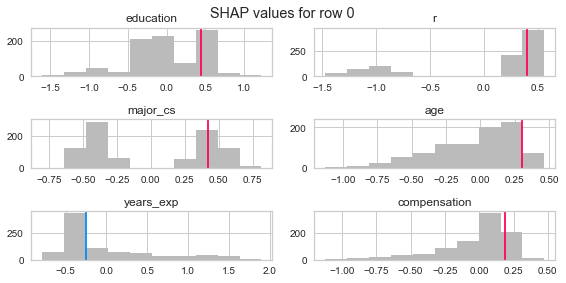

In [13]:
features = ['education', 'r', 'major_cs', 'age', 
            'years_exp', 'compensation']
fig = plot_histograms(shap_df, features, shap_df.iloc[0], 
                      title='SHAP values for row 0')


To output multiple subplots, the figure containing the passed axes is being cleared.


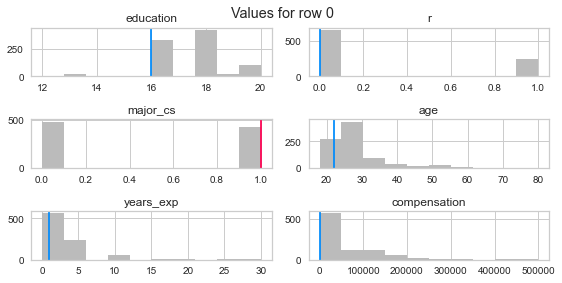

In [14]:
fig = plot_histograms(X_test, features, X_test.iloc[0], title='Values for row 0', color='mean')

<AxesSubplot:>

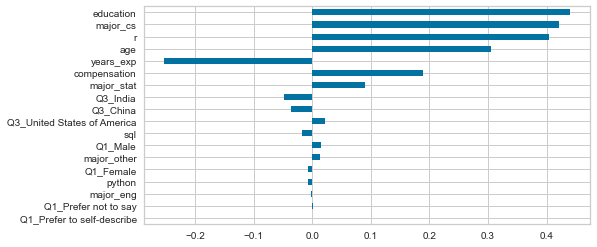

In [15]:
# using the pandas library
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(vals.values[0], index=X_test.columns)
.sort_values(key=np.abs)
.plot.barh(ax=ax)
)

## 19.4 A Force Plot
The shap library also provides a flattened version of the waterfall plot, called a force plot. (In
my example, I show matplotlib=True, but in Jupyter, you can leave that out and the plot will
have some interactivity.)

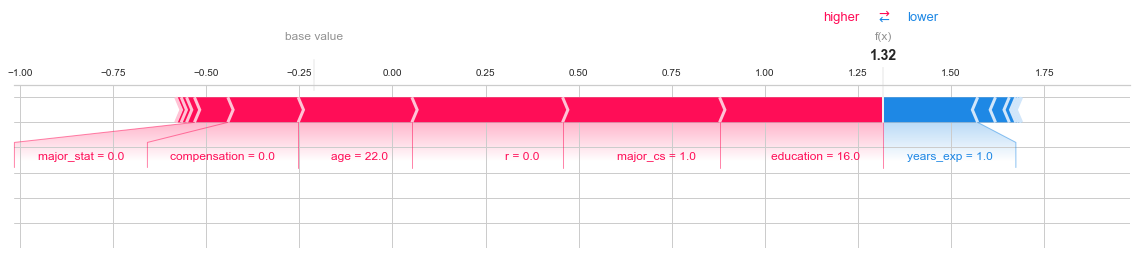

In [16]:
# use matplotlib if having js issues
# blue - DS
# red - Software Engineer
# to save need both matplotlib=True, show=False
res = shap.plots.force(base_value=vals.base_values,
shap_values=vals.values[0,:], features=X_test.iloc[0],
matplotlib=True, show=False
)
res.savefig('img/shap_forceplot0.png', dpi=600, bbox_inches='tight')

19.5 Force Plot with Multiple Predictions
The shap library allows you to pass in multiple rows of SHAP values into the force function.
In that case, it flips them vertically and stacks them next to each other. There currently is no
Matplotlib version for this plot, and the Jupyter/JavaScript version has a dropdown to change
the order of the results and a dropdown to change what features it shows.

In [17]:
# First n values
n = 100
# blue - DS
# red - Software Engineer
shap.plots.force(base_value=vals.base_values,
shap_values=vals.values[:n,:], features=X_test.iloc[:n],
)

## 19.6 Understanding Features with Dependence Plots
Because the shap library has computed SHAP values for every feature, we can use that to
visualize how features impact the model. The Dependence Scatter Plot shows the SHAP values
across the values for a feature. This plot can be a little confusing at first, but when you take a
moment to understand it, it becomes very useful.
Let’s pick one of the features that had a big impact on our model, education.

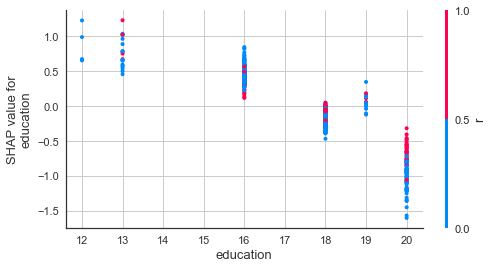

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'education'], ax=ax, color=vals,
x_jitter=0, hist=False)

SHAP values are a method based on cooperative game theory used to increase transparency and interpretability of machine learning models ³. They show how much each feature contributes, either positively or negatively, to the target variable.

In this specific example, the plot shows how different levels of `education` interact with other features to affect the prediction of whether a respondent's job title is "Data Scientist" or "Software Engineer". The y-axis shows the SHAP values for each level of education, which can be positive or negative depending on how that level of education interacts with other features. For example, higher compensation may push more towards the "Software Engineer" label for lower levels of education.

A practical example of using SHAP values could be in credit risk modeling. A bank could use a machine learning model to predict whether a loan applicant is likely to default on their loan. The model could take into account various features such as income, credit score, and employment history. By using SHAP values, the bank could see how much each feature contributes to the prediction and better understand why the model made a certain decision. For example, if an applicant is predicted to be at high risk of defaulting, the bank could use SHAP values to see that it was primarily due to their low credit score and high debt-to-income ratio. This information could help the bank make more informed decisions and provide better explanations to applicants.

## 19.7 Jittering a Dependence Plot

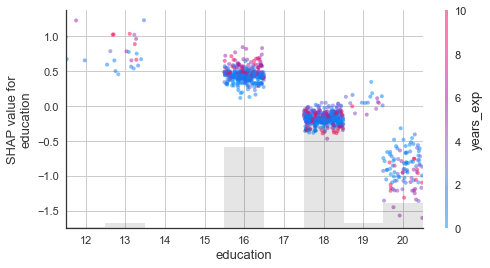

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'education'], ax=ax,
                   color=vals[:, 'years_exp'], x_jitter=1, alpha=.5)

This plot makes it very clear that most of the education entries have values of 16 and 18.
Based on the SHAP values, having more schooling pushes toward data science.
You can also see a faint histogram. Because most values have an education level above
15, you might want to explore whether the model is overfitting the values for 12 and 13. The
value for 19 might warrant exploration as there are few entries there.
The jittering and histogram functionality is automatic when you use the scatter function.
Let’s explore one more dependence plot showing the impact of the major_cs column. We
will choose the R column for the interaction index.


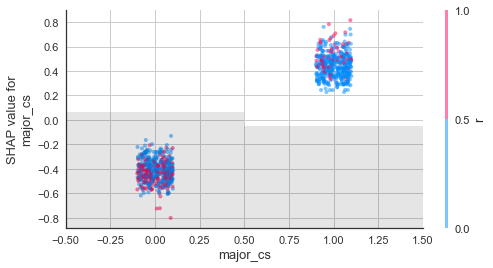

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'major_cs'], ax=ax, color=vals[:, 'r'], alpha=.5)

This plot suggests that having a background in computer science is more strongly associated with the "Software Engineer" label than with the "Data Scientist" label. Interestingly, the addition of proficiency in the R programming language to a computer science background appears to further strengthen this association, contrary to what one might expect. It is important to note that these observations are based on the specific data and model used in this example and may not necessarily generalize to other datasets or models.

## 19.8 Heatmaps and Correlations

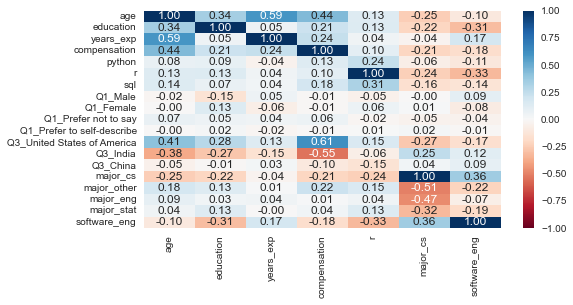

In [21]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
_=sns.heatmap(X_test
    .assign(software_eng=y_test)
    .corr(method='spearman')
    .loc[:, ['age', 'education', 'years_exp', 
             'compensation', 'r', 'major_cs', 'software_eng']],
    cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
)


A heatmap can be used to visualize the correlation between the SHAP values of different features for each prediction. This allows us to see if two features tend to have a similar or opposite effect on the prediction. For instance, in this example, the SHAP values for both `education` and `major_stat` push the prediction label in the same direction. By examining these correlations, we can gain a deeper understanding of how different features interact and influence the model's predictions.

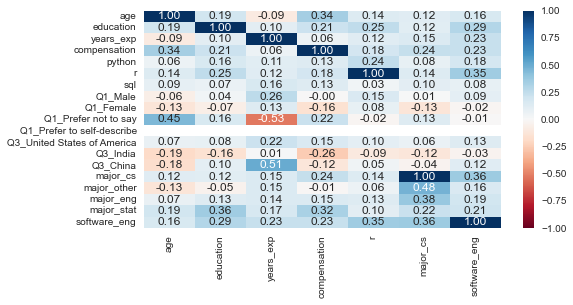

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))

_=sns.heatmap(shap_df
    .assign(software_eng=y_test)
    .corr(method='spearman')
    .loc[:, ['age', 'education', 'years_exp', 'compensation', 'r', 'major_cs','software_eng']],
    cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
               )

When interpreting correlation heatmaps, it is often useful to focus on the values that are either dark red or dark blue (depending on the color scheme you chose, we used `cmap='RdBu'` in our case), while ignoring the self-correlation values. In this example, we can see that there is a positive correlation between the SHAP values for compensation and age. This means that as the SHAP value for age increases, the SHAP value for compensation also tends to increase. It is important to note that this correlation between SHAP values is distinct from the correlation between the actual non-SHAP values of these features. To further explore these relationships, one could create a scatter plot to visualize the relationship between these two features.

## 19.9 Beeswarm Plots of Global Behavior

One of the strengths of SHAP is its ability to provide both local and global explanations of a model's predictions and feature interactions. The beeswarm or summary plot is a useful tool for visualizing the global impact of features on the model. This plot displays a rank-ordered list of features according to their impact on the final prediction, with the SHAP value shown on the x-axis. Positive values indicate a push towards the positive label. Each feature is color-coded to represent high (red) or low (blue) values.

For example, in this plot, the `r` feature is binary and has only red and blue values. A high value (1) for this feature results in a significant push towards the "Data Scientist" label. The spread of red values suggests that there may be interactions with other features that influence the model's predictions. In contrast, the `years_exp` feature has multiple possible values and shows a smooth gradation from blue to red. This is in contrast to the `education` feature, which displays non-monotonic behavior with alternating red, purple, red, and blue values.

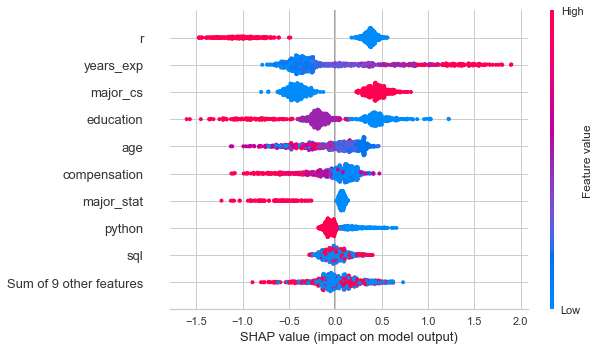

In [23]:
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals)

To display all of the features in a SHAP plot, the max_display parameter can be used. Additionally, the colormap can be changed to a Matplotlib colormap that is more suitable for grayscale displays. This is particularly useful for those who are viewing the plot in a physical edition that is printed in grayscale.

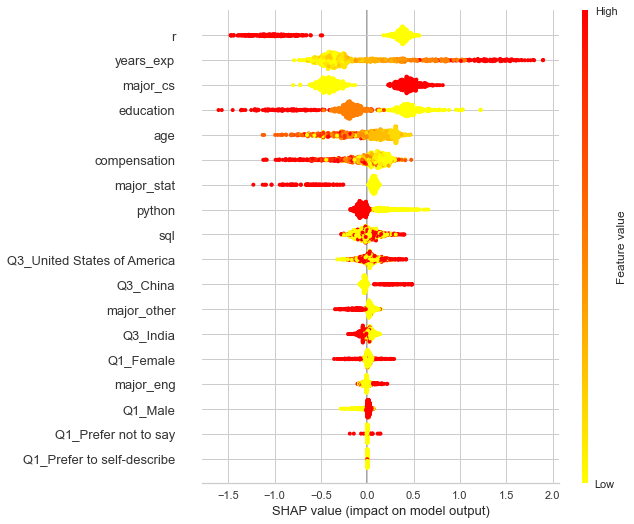

In [24]:
from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals, max_display=len(X_test.columns), color=cm.autumn_r)

## 19.10 SHAP with No Interaction
If your model has interactions, SHAP values will reflect them. If we remove interactions, you
will simplify your model (by making the max_depth equal to 1). It will also make non-linear
responses more clear.
Let’s train a model of stumps and look at some of the SHAP plots.

In [25]:
no_int_params = {'random_state': 42,'max_depth': 1}

xg_no_int = xgb.XGBClassifier(**no_int_params, early_stopping_rounds=50, n_estimators=500)

xg_no_int.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), 
                        (X_test, y_test)], verbose=False)

xg_no_int.score(X_test, y_test)

0.7370165745856354

In [26]:
shap_ind = shap.TreeExplainer(xg_no_int)
shap_ind_vals = shap_ind(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


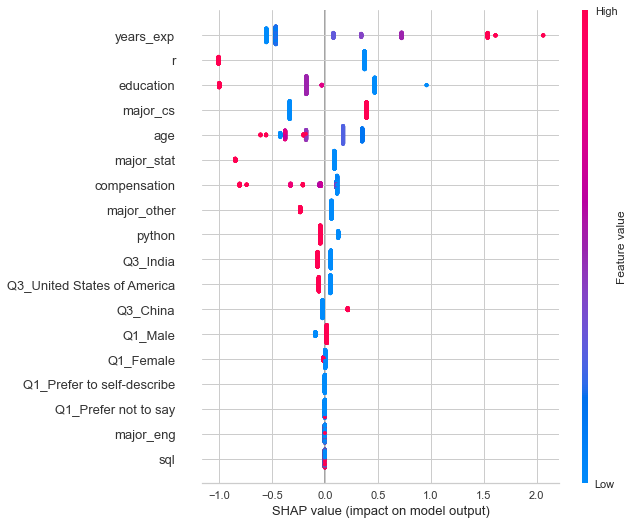

In [27]:
from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(shap_ind_vals, max_display=len(X_test.columns))

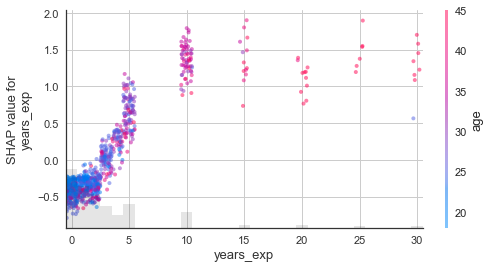

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(vals[:, 'years_exp'], ax=ax, color=vals[:, 'age'], alpha=.5, x_jitter=1)

This code creates a scatter plot using the `shap.plots.scatter` function from the SHAP library. The first line creates a new figure and axes object using the `subplots` function from the Matplotlib library. The `figsize` parameter is used to specify the size of the figure.

The second line calls the `shap.plots.scatter` function to create a scatter plot on the specified axes object (`ax`). The x-coordinates of the points in the scatter plot are given by the `years_exp` column of the `shap_ind_vals` array. The `color` parameter is used to specify the colors of the points, which are determined by the values in the `age` column of the `shap_ind_vals` array. The `alpha` parameter is used to set the transparency of the points, and the `x_jitter` parameter is used to add some random noise to the x-coordinates of the points to make it easier to see overlapping points.

invalid value encountered in true_divide
invalid value encountered in true_divide


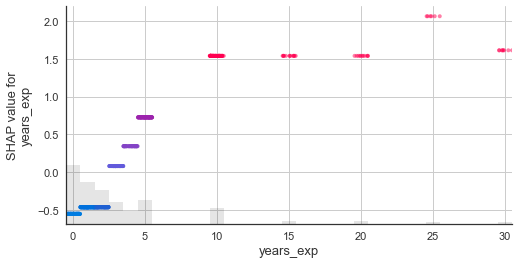

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.plots.scatter(shap_ind_vals[:, 'years_exp'], ax=ax, color=shap_ind_vals[:, 'age'], alpha=.5, x_jitter=1)

## Summary
1. SHAP can be used to explain a model's global behavior by providing a summary of the average impact of each feature on the model's predictions. It can also be used to explain a model's local behavior by providing detailed explanations of individual predictions, including the impact of each feature on the prediction result.

2. The waterfall plot displays the impact of each feature on the prediction result by showing how the prediction changes as each feature is added to the model. The plot starts with the base value (the average prediction for the dataset) and then adds the impact of each feature in turn, showing how the prediction changes as a result.

3. The force plot displays the impact of features on the model by showing how each feature pushes the prediction higher or lower. Features that push the prediction higher are shown in red, while features that push the prediction lower are shown in blue. The length of each bar represents the magnitude of the feature's impact.

4. The summary plot displays a rank-ordered list of features according to their impact on the final prediction, with the SHAP value shown on the x-axis. This helps to interpret feature importance by showing which features have the greatest impact on the model's predictions.

5. The dependence plot helps to identify non-monotonic behavior by plotting the SHAP value for a given feature against its actual value for all instances in the dataset. If a feature displays non-monotonic behavior, this will be visible as a non-linear relationship between its SHAP value and its actual value.

6. The summary plot can help identify features with non-monotonic behavior by displaying a color gradient for each feature that represents its actual value. If a feature displays non-monotonic behavior, this will be visible as an irregular color gradient.

7. The summary plot can help to identify features that have interacted with other features by displaying a spread of SHAP values for each feature. If a feature has interacted with other features, this will be visible as a spread of SHAP values that cannot be explained by its actual value alone.